In [1]:
import collections
import dataclasses

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
graph = nx.read_graphml("../../../scripture_graph.graphml")
graph_lib.remove_topic_nodes(graph)
graph_lib.remove_suggested_edges(graph)

48566 166449
41995 45985


In [3]:
nx.reciprocity(graph)

0.8280526258562575

In [4]:
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 41995
Number of edges: 45985
Average in degree:   1.0950
Average out degree:   1.0950


In [5]:
print(nx.number_weakly_connected_components(graph))
print(nx.number_strongly_connected_components(graph))

24005
26721


# Weakly Connected Components

In [6]:
sizes = []
for component in nx.weakly_connected_components(graph):
    sizes.append(len(component))
sizes = np.asarray(sizes)

x = np.unique(sizes)
y = np.asarray([np.count_nonzero(sizes == size) for size in x])
df = pd.DataFrame({"size": x, "count": y})
df

,size,count
0,1,22243
1,2,1159
2,3,342
3,4,124
4,5,63
5,6,23
6,7,12
7,8,15
8,9,7
9,10,7


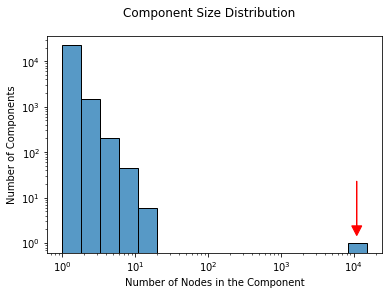

In [7]:
fig, ax = subplots()
sns.histplot(sizes, log_scale=True, ax=ax)
ax.set_yscale("log")
ax.set_ylabel("Number of Components")
ax.set_xlabel("Number of Nodes in the Component")
fig.suptitle("Component Size Distribution")
# Add an arrow.
ax.arrow(0.925, 0.33, 0, -0.25, transform=ax.transAxes, head_width=0.03, color="red", length_includes_head=True)
fig.savefig("component-size.png", dpi=300, bbox_inches="tight")

In [8]:
# Prune the graph to the largest strongly connected component.
# How many edges does it have?
nodes = None
for component in nx.weakly_connected_components(graph):
    if len(component) > 1000:
        nodes = component
        break
subgraph = nx.subgraph(graph, nodes)
print(graph.number_of_nodes())
print(graph.number_of_edges())
print(subgraph.number_of_nodes())
print(subgraph.number_of_edges())

41995
45985
15004
40011


In [9]:
# Percentage of singletons (no incoming *or* outgoing edges)
count = 0
for node, degree in graph.degree():
    if degree == 0:
        count += 1
print(count, count / graph.number_of_nodes())

22243 0.5296582926538874


In [10]:
# Percentage of non-singletons in the largest component.
subgraph.number_of_nodes() / (graph.number_of_nodes() - count)

0.7596192790603483

In [11]:
# Percentage of verses.
print(subgraph.number_of_nodes() / graph.number_of_nodes())

0.3572806286462674


In [12]:
# Percentage of cross-references.
print(subgraph.number_of_edges() / graph.number_of_edges())

0.8700880721974557


# Centrality

In [13]:
def assign_ranks(scores):
    rows = []
    for key, value in scores.items():
        rows.append({"verse": key, "score": value})
    df = pd.DataFrame(rows)
    df["rank"] = scipy.stats.rankdata(-1 * df.score.values, method="min")
    return df.sort_values(["rank", "verse"], ignore_index=True)

In [14]:
degree_df = assign_ranks(nx.in_degree_centrality(subgraph))
degree_df.head(10)

,verse,score,rank
0,D&C 17:1,0.001800,1
1,D&C 1:38,0.001800,1
2,1 Ne. 17:35,0.001666,3
3,Hel. 12:3,0.001666,3
4,D&C 1:14,0.001600,5
5,1 Ne. 19:10,0.001533,6
6,2 Ne. 25:20,0.001533,6
7,Moses 6:57,0.001533,6
8,D&C 1:16,0.001400,9
9,D&C 88:63,0.001400,9


In [15]:
pagerank_df = assign_ranks(nx.pagerank(subgraph))
pagerank_df.head(10)

,verse,score,rank
0,D&C 1:38,0.000574,1
1,1 Ne. 17:35,0.000562,2
2,Mosiah 4:26,0.000554,3
3,Hel. 12:3,0.000520,4
4,2 Ne. 9:37,0.000484,5
5,D&C 1:14,0.000471,6
6,D&C 17:1,0.000460,7
7,D&C 88:63,0.000459,8
8,Moses 6:57,0.000457,9
9,2 Ne. 9:28,0.000442,10


In [16]:
merged = degree_df.merge(pagerank_df, on="verse", suffixes=("_degree", "_pagerank"))
assert len(merged) == len(degree_df) == len(pagerank_df)
merged["in_degree"] = [subgraph.in_degree(verse) for verse in merged.verse.values]
merged["out_degree"] = [subgraph.out_degree(verse) for verse in merged.verse.values]
merged = merged.sort_values(["rank_degree", "rank_pagerank"])
merged.head()

,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
1,D&C 1:38,0.001800,1,0.000574,1,27,19
0,D&C 17:1,0.001800,1,0.000460,7,27,19
2,1 Ne. 17:35,0.001666,3,0.000562,2,25,17
3,Hel. 12:3,0.001666,3,0.000520,4,25,9
4,D&C 1:14,0.001600,5,0.000471,6,24,16


In [17]:
topk = set(merged.verse.values[:10])
topk.update(set(merged.sort_values("rank_pagerank").verse.values[:10]))
merged[merged.verse.isin(topk)]

,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
1,D&C 1:38,0.001800,1,0.000574,1,27,19
0,D&C 17:1,0.001800,1,0.000460,7,27,19
2,1 Ne. 17:35,0.001666,3,0.000562,2,25,17
3,Hel. 12:3,0.001666,3,0.000520,4,25,9
4,D&C 1:14,0.001600,5,0.000471,6,24,16
7,Moses 6:57,0.001533,6,0.000457,9,23,15
6,2 Ne. 25:20,0.001533,6,0.000376,18,23,21
5,1 Ne. 19:10,0.001533,6,0.000342,27,23,33
9,D&C 88:63,0.001400,9,0.000459,8,21,15
8,D&C 1:16,0.001400,9,0.000378,17,21,14


In [18]:
# Calculate the rank correlation; we don't necessarily expect/need the relationship to be linear (i.e. pearson)
t, _ = scipy.stats.kendalltau(merged.score_degree.values, merged.score_pagerank.values)
r, _ = scipy.stats.spearmanr(merged.score_degree.values, merged.score_pagerank.values)
print(t, r**2)

0.7273579435433243 0.7403503305714518


In [19]:
merged[merged.verse.isin(["1 Ne. 19:10", "2 Ne. 9:37", "2 Ne. 9:28", "2 Ne. 25:20", "D&C 1:16", "Mosiah 4:26"])]

,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
6,2 Ne. 25:20,0.001533,6,0.000376,18,23,21
5,1 Ne. 19:10,0.001533,6,0.000342,27,23,33
8,D&C 1:16,0.001400,9,0.000378,17,21,14
10,2 Ne. 9:28,0.001333,11,0.000442,10,20,20
26,Mosiah 4:26,0.001133,22,0.000554,3,17,10
121,2 Ne. 9:37,0.000800,112,0.000484,5,12,1


In [20]:
neighbors = [source for source, _ in subgraph.in_edges("2 Ne. 9:37")]
df = merged[merged.verse.isin(neighbors)]
print(sum(df.score_pagerank / df.out_degree))
df

0.0006020219650788545


,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
353,Alma 7:6,0.000600,321,0.000126,1578,9,3
2035,Hel. 6:31,0.000333,1482,0.000102,2720,5,6
2985,Deut. 31:16,0.000267,2341,0.000096,3077,4,6
3370,Judg. 2:17,0.000267,2341,0.000083,4133,4,6
4876,Ezek. 18:6,0.000200,3695,0.000095,3167,3,4
4221,Alma 31:1,0.000200,3695,0.000060,6629,3,4
4848,Ex. 34:14,0.000200,3695,0.000054,7551,3,6
12224,Isa. 41:24,0.000067,9373,0.000438,11,1,1
12820,Lev. 19:4,0.000067,9373,0.000020,13632,1,3
13719,Ps. 16:4,0.000067,9373,0.000019,13728,1,5


In [21]:
neighbors = [source for source, _ in subgraph.in_edges("2 Ne. 9:28")]
df = merged[merged.verse.isin(neighbors)]
print(sum(df.score_pagerank / df.out_degree))
df

0.000507337624048382


,verse,score_degree,rank_degree,score_pagerank,rank_pagerank,in_degree,out_degree
56,2 Ne. 26:20,0.000933,56,0.000235,146,14,17
175,2 Ne. 19:17,0.000733,168,0.000184,418,11,9
292,Jacob 4:10,0.000667,224,0.000220,201,10,9
1072,Alma 37:12,0.000400,942,0.000126,1571,6,6
1802,D&C 35:7,0.000333,1482,0.000113,2115,5,5
3590,Prov. 15:22,0.000267,2341,0.000094,3278,4,5
3003,Eccl. 10:12,0.000267,2341,0.000093,3309,4,4
3589,Prov. 14:6,0.000267,2341,0.000091,3496,4,4
4606,D&C 76:9,0.000200,3695,0.000101,2791,3,2
4895,Ezek. 28:5,0.000200,3695,0.000093,3287,3,3


# Hubs and Authorities

In [22]:
hubs, authorities = nx.hits(subgraph, max_iter=1000)

In [23]:
assign_ranks(hubs).head(10)

,verse,score,rank
0,1 Ne. 19:10,0.031958,1
1,2 Ne. 26:12,0.014952,2
2,D&C 19:27,0.011969,3
3,Mosiah 7:19,0.009277,4
4,1 Ne. 13:42,0.008466,5
5,2 Ne. 19:6,0.008402,6
6,D&C 8:3,0.008264,7
7,D&C 18:26,0.007530,8
8,Moro. 7:22,0.007482,9
9,D&C 18:6,0.007175,10


In [24]:
assign_ranks(authorities).head(10)

,verse,score,rank
0,Mosiah 7:19,0.016047,1
1,1 Ne. 19:10,0.013568,2
2,2 Ne. 25:20,0.012836,3
3,Mosiah 7:27,0.012790,4
4,2 Ne. 26:12,0.011802,5
5,Alma 11:39,0.010591,6
6,2 Ne. 10:3,0.010536,7
7,3 Ne. 11:14,0.009601,8
8,D&C 19:27,0.009090,9
9,1 Ne. 13:42,0.008591,10
